In [192]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import scipy.stats
import seaborn as sns

In [193]:
basedf = pd.read_csv('measured_data/log_theatre1.txt',sep='|')
movedf = pd.read_csv('measured_data/log_theatre2.txt',sep='|')

In [194]:
def getProcessedDF(initialdf):
    
    splitpos = []
    for index, row in initialdf.iterrows():
       timestamp = row['Time Stamp']
       if timestamp == 'Time Stamp':
            splitpos.append(index)
    dfs = np.split(initialdf, splitpos, axis=0)
    
    def deleteHead(df):
        return df.iloc[1:]
    def makeNumeric(df):
        df.RSSI = df.RSSI.apply(float)
        return df
    def averageRSSI(df):
        return df.groupby('BSSID', as_index=False).mean()
    def sortByRSSI(df):
        return df.sort_values('RSSI',ascending=False)
    def getDist(df):
        return float((df['dist'].iloc[0]))

    dfs = list(map(deleteHead,dfs))
    dists = np.array(list(map(getDist,dfs)))

    dfs = list(map(makeNumeric,dfs))
    dfs = list(map(averageRSSI,dfs))
    dfs = list(map(sortByRSSI,dfs))
    return dfs, dists # for single sample example





In [195]:
def getRankDict(df):
        rankdict = {}
        for index in range(len(df)):
            row = df.iloc[index]
            rankdict[row['BSSID']] = index
        return rankdict

In [196]:
basedfs, basedists = getProcessedDF(basedf)
movedfs, movedists = getProcessedDF(movedf)
dists = movedists
print(len(dists),len(basedists))
def getSpearmanDicts(dfs):
    spearmanDicts = []
    for i in range(0,len(dfs)):
        spearmanDicts.append(getRankDict(dfs[i]))
    return spearmanDicts
#some random headers in datafrAMES !!
baseSpearmanDicts = getSpearmanDicts(basedfs)
moveSpearmanDicts = getSpearmanDicts(movedfs)


14 14


In [197]:
def getSpearmans(dict1,dict2):
    intersection = set(dict1.keys()) & set(dict2.keys())
    result = []
    for k in intersection:
        result.append((dict1[k],dict2[k]))
    result = np.array(result)
    resValue,cor = scipy.stats.spearmanr(result)
    print(cor)
    return resValue

In [198]:
def  getJacard(dict1,dict2):
    set1 = set(dict1.keys())
    set2 = set(dict2.keys())
    print(len(set1 & set2),len(set1),len(set2))
    jacard = len(set1 & set2) / len(set1 | set2)
    return jacard

In [199]:
spearmans = []
jacards = []
for base,df in zip(baseSpearmanDicts,moveSpearmanDicts):
    spearmans.append(getSpearmans(df,base))
    jacards.append(getJacard(df,base))
    
modelInput = np.array([spearmans,jacards])
Y = np.array(dists)

8.509307188619566e-13
41 56 44
4.8563455591821973e-14
41 54 50
9.978937067588658e-16
45 55 52
5.94723971408662e-11
44 55 53
6.130760918103444e-12
46 58 49
8.843785727045126e-09
34 38 46
1.1145844191633471e-13
47 55 50
3.432687343970062e-10
32 45 43
3.397688250597222e-11
42 50 48
1.5525856798341324e-09
31 40 41
1.68642343748401e-09
35 54 42
1.0384482884717002e-09
40 50 52
4.693312447019872e-07
33 52 40
5.1574552748139653e-08
38 48 49


In [200]:
labels = Y[:,np.newaxis]
X = modelInput.swapaxes(1,0)

In [201]:
#X = np.expand_dims(X[:,0],axis=1)

In [202]:
model = LinearRegression()

In [203]:
cv

{'fit_time': array([0.        , 0.00099707, 0.00098395, 0.        , 0.00099826,
        0.00099778, 0.        , 0.0009954 , 0.00099826, 0.        ]),
 'score_time': array([0.0009985 , 0.        , 0.        , 0.00099349, 0.00099587,
        0.        , 0.00099778, 0.        , 0.        , 0.        ]),
 'test_score': array([-15.51670138,  -9.05725341, -12.51893504,  -7.59945962,
         -4.99460293,  -7.23055083,  -5.51744045,  -9.96560472,
         -2.16462176,  -4.92076842]),
 'train_score': array([-4.82609157, -5.39280027, -4.90135547, -5.69052444, -5.82428454,
        -5.7947653 , -5.797666  , -5.49712955, -6.06432268, -5.90790771])}

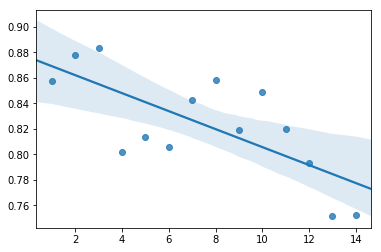

In [204]:
sns.regplot(labels[:,0],X[:,0])

In [205]:
model.fit(X,labels)
for a in zip(model.predict(X),labels):
    print(a)

(array([4.85100743]), array([1.]))
(array([4.28147341]), array([2.]))
(array([2.62399023]), array([3.]))
(array([8.5481671]), array([4.]))
(array([6.61696927]), array([5.]))
(array([8.43057929]), array([6.]))
(array([3.76647848]), array([7.]))
(array([6.95366264]), array([8.]))
(array([6.35821854]), array([9.]))
(array([6.68102893]), array([10.]))
(array([9.39196447]), array([11.]))
(array([9.86605667]), array([12.]))
(array([14.08909007]), array([13.]))
(array([12.54131347]), array([14.]))


In [206]:
import pickle

In [207]:
f = open('modeldata','wb')

In [208]:
pickle.dump(model,f)

In [209]:
f.close()

In [210]:
f = open('modeldata','rb')
model2 = pickle.load(f)


In [211]:
model2.fit(X,labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [212]:
model2.coef_

array([[-64.82117334, -17.54966977]])

In [213]:
model2.intercept_

array([72.60754639])